**import libraries**

In [1]:
import random
import gym
import keras
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Nadam
from keras.optimizers import Adam
from IPython.display import HTML

import os
import math
from typing import Optional, Union
from gym import logger, spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled
import time
import random
from tensorflow.keras.models import load_model

**Custom Environment**

In [2]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""
import math
from typing import Optional, Union

import numpy as np

import gym
from gym import logger, spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled


class CartPole(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    """
    ### Description

    This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.

    ### Action Space

    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
     of the fixed force the cart is pushed with.

    | Num | Action                 |
    |-----|------------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |

    **Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle
     the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

    ### Observation Space

    The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

    | Num | Observation           | Min                 | Max               |
    |-----|-----------------------|---------------------|-------------------|
    | 0   | Cart Position         | -4.8                | 4.8               |
    | 1   | Cart Velocity         | -Inf                | Inf               |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
    | 3   | Pole Angular Velocity | -Inf                | Inf               |

    **Note:** While the ranges above denote the possible values for observation space of each element,
        it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:
    -  The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates
       if the cart leaves the `(-2.4, 2.4)` range.
    -  The pole angle can be observed between  `(-.418, .418)` radians (or **±24°**), but the episode terminates
       if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)

    ### Rewards

    Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken,
    including the termination step, is allotted. The threshold for rewards is 475 for v1.

    ### Starting State

    All observations are assigned a uniformly random value in `(-0.05, 0.05)`

    ### Episode End

    The episode ends if any one of the following occurs:

    1. Termination: Pole Angle is greater than ±12°
    2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
    3. Truncation: Episode length is greater than 500 (200 for v0)

    ### Arguments

    ```
    gym.make('CartPole-v1')
    ```

    No additional arguments are currently supported.
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(self, render_mode: Optional[str] = None):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.5
        self.total_mass = self.masspole + self.masscart
        self.length = 0.25  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = "euler"
        #self.initial_angle = 25*math.pi/180


        # Angle at which to fail the episode
        self.theta_threshold_radians = 12*math.pi/180
        self.x_threshold = 0.5

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                self.theta_threshold_radians * 2,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state = None

        self.steps_beyond_terminated = None

    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * theta_dot**2 * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        terminated = bool(
            x < -1*self.x_threshold
            or x > 1*self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not terminated:
            reward = 1.0
        elif self.steps_beyond_terminated is None:
            # Pole just fell!
            self.steps_beyond_terminated = 0
            reward = 1.0
        else:
            if self.steps_beyond_terminated == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned terminated = True. You "
                    "should always call 'reset()' once you receive 'terminated = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_terminated += 1
            reward = 0.0

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

    def reset(self,*,seed: Optional[int] = None,options: Optional[dict] = None,start_angle: Optional[float] = None,):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05 ) # default low        )  # default high

        if start_angle is not None:
            assert -self.theta_threshold_radians <= start_angle <= self.theta_threshold_radians, \
                "Starting angle must be within the allowed range"
            self.state = np.array([0.0, 0.0, start_angle, 0.0])
        else:
            self.state = self.np_random.uniform(low=low, high=high, size=(4,))

        self.steps_beyond_terminated = None
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

**Define Environment**

In [3]:
env = CartPole(render_mode='human')
env.force_mag = 20.0
env.theta_threshold_radians = 40*math.pi/180
# angle = 30*math.pi/180
# env.reset(start_angle = angle )
env.reset()

(array([ 0.02849293,  0.03685264, -0.04455807, -0.03831967], dtype=float32),
 {})

**States & Actions**

In [4]:
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

**Building the Model**

In [2]:
class DDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000) # deque is like list and we can append elements to it.
        self.gamma = 0.95 # discount rate.
        self.epsilon = 1.0 # exploration rate: how much to act randomly.
        self.epsilon_decay = 0.995 # decrease number of random explorations as the agent's performance improves.
        self.epsilon_min = 0.01 # minimum amount of random exploration permitted.
        self.learning_rate = 0.001 # learning rate.
        self.train_counter = 0
        self.update_target_freq = 20
        self.online_model = self._build_model() # This is a private method
        self.target_model = self._build_model()
        self.update_target_model()

    #==============================================================================================
    #Step 2

    def _build_model(self):
        # neural net to approximate Q-value function.# Q is a f of s,a,theta
        model = Sequential()
        model.add(Dense(64, activation='relu', input_dim=self.state_size))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear')) # 2 actions. 2 output neurons: 0 and 1 (L/R)
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=self.learning_rate)) # You can change this to Adam or other optimisers.
        return model

    #==================================================================================================

    #Step 3
    def update_target_model(self):
        self.target_model.set_weights(self.online_model.get_weights())

    def remember(self, state, action, reward, next_state, done): # done means game is over or final or early termination.
        self.memory.append((state, action,
                            reward, next_state, done)) # list of previous experiences, enabling re-training later
     #=====================================================================================================

    # Step 4

    def train(self, batch_size): # method that trains NN with experiences sampled from memory
        minibatch = random.sample(self.memory, batch_size) # sample a minibatch from memory
        for state, action, reward, next_state, done in minibatch:
            if done:
                target = reward
            else:
                next_action = np.argmax(self.online_model.predict(next_state)[0])
                Q_next = np.amax(self.target_model.predict(next_state)[0][next_action])
                target = reward + self.gamma * Q_next
            target_f = self.target_model.predict(state)
            target_f[0][action] = target
            self.online_model.fit(state, target_f, epochs=1, verbose=0) #NN to see which action is optimal,given s
            self.train_counter +=1
            if self.train_counter % self.update_target_freq == 0: # Update target network every n steps
                self.update_target_model()
                self.train_counter = 0
        if self.epsilon > self.epsilon_min: 
            self.epsilon *= self.epsilon_decay # Here we are adjusting the value of epsilon if the condition is true.

    def act(self, state):
        if np.random.rand() <= self.epsilon: # if acting randomly, take random action. take a random no from 0 to 1.
            return random.randrange(self.action_size) # The agent at this stage will explore
        act_values = self.online_model.predict(state) # if not acting randomly, predict reward value based on current state
        # As time progresses, the agent will take less random action=> the agent will exploit.
        # Our model will be used to predict the highest reward based on two actions.
        return np.argmax(act_values[0]) # pick the action that will give maximise the agent reward (left or right)

    #============================================================================================================

In [150]:
saved_model = keras.models.load_model("DDQN100invertedPendulum_F10_0.5x_x0.5_freq10_theta20_25.h5")

**Define Agent**

In [124]:
agent = DDQNAgent(state_size, action_size)
agent.update_target_freq = 10
agent.online_model = saved_model
agent.target_model = saved_model
agent.epsilon = 0.0

**Training**

In [156]:
batch_size = 32
n_episodes = 100
duration = 60
for e in range(n_episodes):  # iterate over episodes of gameplay
    start_time = time.time()
    #angle = np.random.uniform(-20*math.pi/180,20*math.pi/180)
    a = random.random()
    if a>0.5:
        angleInDegree = np.random.uniform(-30,-25)
    else:
        angleInDegree = np.random.uniform(25,30)
    starting_angle = angleInDegree*math.pi/180
    state = env.reset(start_angle = starting_angle)  # reset state and get four random states.
    state = np.reshape(state[0], [1, state_size])  # To pass this to the NN.
    done = False
    timee = 0  # goal is to keep pole upright as long as possible.
    while not done:
        # This while loop ends if we get to 200 timesteps or the pole falls, or cart disappears from the screen.
        action = agent.act(state)  # Given the state, the agent takes an action (move cart left or right).
        next_state, reward, done, _, _ = env.step(action)  # agent interacts with env, gets feedback; 4 state data points.
        reward = reward if not done else -10  # reward +1 for each additional frame with pole upright and -10 for ending the game.
        next_state = np.reshape(next_state, [1, state_size])  # To pass this to the NN.
        agent.remember(state, action, reward, next_state, done)  # To remember the previous timestep's state, actions, reward, etc.
        state = next_state  # set current state to the current next state for the next while loop
        if done:  # if episode ends:
            print("episode: {}/{}, score: {}, e: {:.2}".format(e, n_episodes-1, timee, agent.epsilon))  # print the episode's score and agent's epsilon
        timee += 1
        env.render()
        if time.time() - start_time >= duration:
            agent.online_model.save("DDQN350invertedPendulum1x_x0.5_freq20_theta15_25.h5")
            agent.online_model = keras.models.load_model("DDQN350invertedPendulum1x_x0.5_freq20_theta15_25.h5")
            print("episode: {}/{}, score: {}, e: {:.2}".format(e, n_episodes-1, timee, agent.epsilon))
            break  
    if len(agent.memory) > batch_size:
        agent.train(batch_size)

env.close()


1/1 [==============================] - 0s 15ms/step
episode: 0/99, score: 17, e: 0.0
1/1 [==============================] - 0s 16ms/step
episode: 1/99, score: 16, e: 0.0
1/1 [==============================] - 0s 15ms/step
episode: 2/99, score: 17, e: 0.0
1/1 [==============================] - 0s 15ms/step
episode: 3/99, score: 16, e: 0.0
1/1 [==============================] - 0s 15ms/step
episode: 4/99, score: 18, e: 0.0
1/1 [==============================] - 0s 14ms/step
episode: 5/99, score: 18, e: 0.0
1/1 [==============================] - 0s 16ms/step
episode: 6/99, score: 16, e: 0.0
1/1 [==============================] - 0s 14ms/step
episode: 7/99, score: 14, e: 0.0
1/1 [==============================] - 0s 16ms/step
episode: 8/99, score: 14, e: 0.0
1/1 [==============================] - 0s 15ms/step
episode: 9/99, score: 15, e: 0.0
1/1 [==============================] - 0s 15ms/step
episode: 10/99, score: 17, e: 0.0
1/1 [==============================] - 0s 14ms/step
episode: 11/

# Saving the model

In [157]:
agent.online_model.save("DDQN100invertedPendulum_F10_0.5x_x0.5_freq10_theta25_30.h5")
saved_model = keras.models.load_model("DDQN100invertedPendulum_F10_0.5x_x0.5_freq10_theta25_30.h5")

In [202]:
env = CartPole(render_mode='human')
states = env.observation_space.shape[0]
actions = env.action_space.n
env.force_mag = 10.0
env.x_threshold =0.5

angle = 20*math.pi/180
env.reset(start_angle = angle )

(array([0.        , 0.        , 0.34906584, 0.        ], dtype=float32), {})

In [204]:
saved_model = keras.models.load_model("DDQN600invertedPendulum_F10_0.5x_x0.5_freq10_theta0_12.h5")

In [205]:
# Create an instance of the DQNAgent class
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
testA_agent = DDQNAgent(state_size, action_size)
testA_agent.online_model = saved_model
testA_agent.target_model
testA_agent.epsilon = 0.0
num_episodes = 1

In [206]:
import time
X = []
angles = []
position =[]
counter =0
duration = 60

for e in range(num_episodes):  # iterate over episodes of gameplay
    state = env.reset(start_angle = angle)  # reset state and get four random states.
    state = np.reshape(state[0], [1, state_size])  # To pass this to the NN.
    start_time = time.time()
    done = False
    while not done:
        X.append(counter)
        angles.append(state[0][2])
        position.append(state[0][0])
        counter+=1
        # This while loop ends if we get to 200 timesteps or the pole falls, or cart disappears from the screen.
        action = testA_agent.act(state)  # Given the state, the agent takes an action (move cart left or right).
        next_state, reward, done, _, _ = env.step(action)  # agent interacts with env, gets feedback; 4 state data points.
        reward = reward if not done else -10  # reward +1 for each additional frame with pole upright and -10 for ending the game.
        next_state = np.reshape(next_state, [1, state_size])  # To pass this to the NN.
        testA_agent.remember(state, action, reward, next_state, done)  # To remember the previous timestep's state, actions, reward, etc.
        state = next_state  
        env.render()
        if time.time() - start_time >= duration:
            break
        if (time.time()-start_time>=10 and state[0][2]<=5*math.pi/180 and state[0][2]>=-5*math.pi/180):
            env.force_mag = 5
env.close()

1/1 [==============================] - 0s 23ms/step


KeyboardInterrupt: 

In [9]:
angles = np.array(angles)
X = np.array(X)
position = np.array(position)
angles = angles*180/math.pi

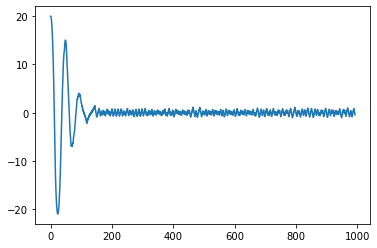

In [10]:
plt.plot(X , angles)

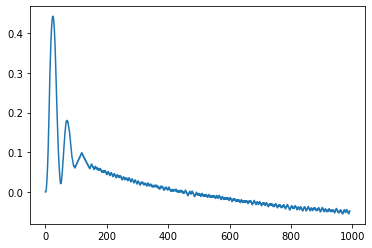

In [11]:
plt.plot(X,position)

In [13]:
np.savetxt("DDQNAngle20.csv", angles, delimiter=",")
np.savetxt("DDQNxAngle20.csv", X, delimiter=",")
np.savetxt("DDQNpositionAngle20.csv", position, delimiter=",")
